# Imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering as SC

# Classes + Helpers

In [3]:
def create_data(N, a=3, b=1, c=1):
  N = int(N)
  x1_pos = a + np.random.randn(int(N/2))
  x2_pos = b + np.random.randn(int(N/2))
  x3_pos = c + np.random.randn(int(N/2))
  x1_neg = -a + np.random.randn(int(N/2))
  x2_neg = -b + np.random.randn(int(N/2))
  x3_neg = -c + np.random.randn(int(N/2))
  return x1_pos, x2_pos, x3_pos, x1_neg, x2_neg, x3_neg

def plot_data(x1_pos, x2_pos, x3_pos, x1_neg, x2_neg, x3_neg):
  fig = plt.figure(figsize=(30, 10))
  ax = fig.add_subplot(projection='3d')
  ax.scatter(x1_pos, x2_pos, x3_pos, c='b')
  ax.scatter(x1_neg, x2_neg, x3_neg, c='r')
  ax.set_title('Linearly separable data - 3D')
  ax.set_xlabel('x1')
  ax.set_ylabel('x2')
  ax.set_zlabel('x3')
  plt.show()
  
def scale_data(x1_pos, x2_pos, x3_pos, x1_neg, x2_neg, x3_neg):
  N = len(x1_pos) + len(x2_pos)
  X = np.zeros((N, 3))
  X[:len(x1_pos), 0] = x1_pos
  X[:len(x2_pos), 1] = x2_pos
  X[:len(x3_pos), 2] = x3_pos
  X[len(x1_pos):, 0] = x1_neg
  X[len(x2_pos):, 1] = x2_neg
  X[len(x3_pos):, 2] = x3_neg

  y = np.concatenate((np.ones(int(N/2)), np.zeros(int(N/2))))
  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)

  return X_scaled, y

def pairwise_distances(X1, X2):
  if (X1.ndim == 1) and (X2.ndim == 1):
    return np.linalg.norm(X1 - X2) ** 2
  elif ((X1.ndim > 1) and (X2.ndim == 1)) or ((X1.ndim == 1) and (X2.ndim > 1)):
    return np.linalg.norm(X1- X2, axis=1) ** 2
  elif (X1.ndim > 1) and (X2.ndim > 1):
    return np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2

In [4]:
class tSNE():

  def __init__(self, sigma=1.0, epochs=1000, lr=100, n_components=2):
    self.sigma = sigma
    self.epochs = epochs
    self.lr = lr
    self.n_components = n_components
  
  def calculate_P(self, X):
    P_num = np.exp(- pairwise_distances(X, X) / (2 * self.sigma**2))
    P_num -= np.diag(np.diag(P_num))
    P_denom = np.sum(P_num, axis=1)
    return (np.divide(P_num, P_denom) + np.divide(P_num, P_denom).T) / (2*self.N)
  
  def calculate_Q(self, Y):
    Q_num = (1 + pairwise_distances(Y, Y)) ** (-1)
    Q_num -= np.diag(np.diag(Q_num))
    Q_denom = Q_num.sum().sum()
    return np.divide(Q_num, Q_denom) 

  def KL_divergence(self, P, Q):
    P_over_Q = np.divide(P, Q)
    no_nan_pos = np.where(~np.isnan(P_over_Q))
    return np.multiply(P[no_nan_pos], np.log(P_over_Q[no_nan_pos])).sum().sum()
  
  def KL_divergence_der(self, Y, P, Q):
    kl_der = np.zeros((Y.shape))
    for i in range(self.N):
      Y_distances = (1 + pairwise_distances(Y[i, :], Y)) ** (-1)
      kl_der[i, :] = 4*np.dot(np.multiply(P[i, :]-Q[i, :], Y_distances).reshape(1,-1), (Y[i, :]-Y)) 
    return kl_der

  def fit_transform(self, X):
    self.N, self.D = X.shape
    if self.D < self.n_components:
      print("'n_components' should >= the dimensionality of the input data")
      return
    else:
      Y = np.random.randn(self.N, self.n_components)
      P = self.calculate_P(X)
      Q = self.calculate_Q(Y)
      for iter in range(self.epochs):
        if iter % 100 == 0:
          kl = self.KL_divergence(P, Q)
          print(f"Iter: {iter} --> KL = {kl}")
        Y -= self.lr * self.KL_divergence_der(Y, P, Q)
        Q = self.calculate_Q(Y)
      return Y

In [11]:
class kMeans():

  def __init__(self, n_clusters=2, max_iters=300, tol=1e-4):
    self.n_clusters = n_clusters
    self.max_iters = max_iters
    self.tol = tol

  def fit(self, X):
    N, D = X.shape
    self.cluster_centers = 0.01*np.random.randn(self.n_clusters, D)
    self.cluster_labels = np.zeros(N)
    for iter in range(self.max_iters):
      if iter % 10 == 0:
        print(f"Iter: {iter}")
      distances = pairwise_distances(X, self.cluster_centers)  
      min_distances = np.min(distances, axis=1)
      if min_distances.max() < self.tol:
        break
      closest_clusters = np.argmin(distances, axis=1)
      for n_cluster in range(self.n_clusters):
        cluster_idxs = np.where(closest_clusters == n_cluster)[0]
        X_cluster = X[cluster_idxs, :]
        self.cluster_centers[n_cluster, :] = np.mean(X_cluster, axis=0)
        self.cluster_labels[cluster_idxs] = n_cluster


In [14]:
class SpectralClustering():
  
  def __init__(self, n_components=2, similarity_type='rbf', sigma=1.0, first_eigval=1):
    self.n_components = n_components
    self.similarity_type = similarity_type
    self.first_eigval = first_eigval
    self.sigma = sigma

  def fit(self, X):
    if self.similarity_type == 'euclidean':
      S = pairwise_distances(X, X)
    elif self.similarity_type == 'rbf':
      S = np.exp(- pairwise_distances(X, X) / (2 * self.sigma**2))
    else:
      print("This value of 'similarity_type' is not supported! \
             Select: 1. 'euclidean' or 2. 'rbf'.")
    L = np.diag(np.sum(S, axis=1)) - S
    self.lambdas, self.V = np.linalg.eigh(L)

  def transform(self):
    self.lambdas, self.V = np.real(self.lambdas), np.real(self.V)
    sort_idx = np.argsort(self.lambdas)
    self.lambdas = self.lambdas[sort_idx][self.first_eigval:self.n_components+1]
    self.V = self.V[:, sort_idx][:, self.first_eigval:self.n_components+1]
    return self.V
  
  def fit_transform(self, X):
    self.fit(X)
    return self.transform()

# MAIN

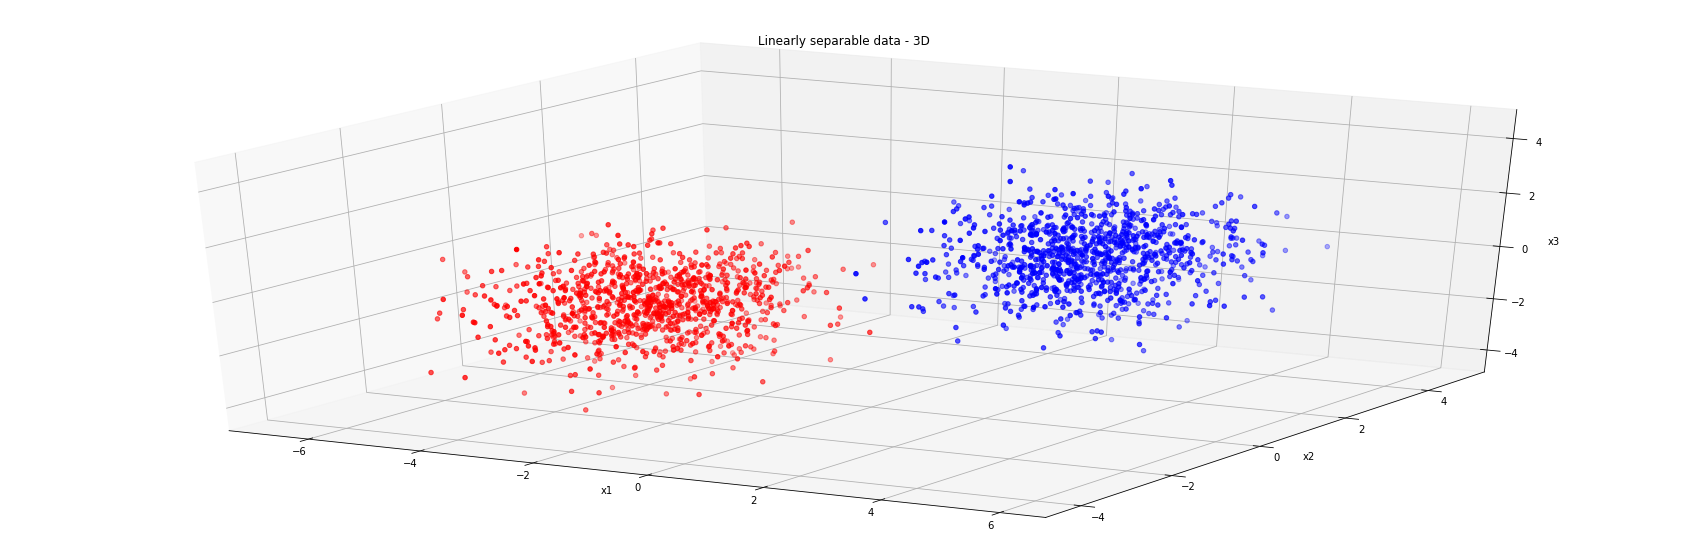

(2000, 3) (2000,)


In [7]:
np.random.seed(7)
N = 2000
x1_pos, x2_pos, x3_pos, x1_neg, x2_neg, x3_neg = create_data(N)
plot_data(x1_pos, x2_pos, x3_pos, x1_neg, x2_neg, x3_neg)
X_scaled, y = scale_data(x1_pos, x2_pos, x3_pos, x1_neg, x2_neg, x3_neg)
print(X_scaled.shape, y.shape)

## t-SNE

In [8]:
EPOCHS = 1000
lr = 200
tsne = tSNE(lr=lr, epochs=EPOCHS)
X_tsne = tsne.fit_transform(X_scaled)

<ipython-input-4-f3be76e5175e>:22: RuntimeWarning: invalid value encountered in true_divide
  P_over_Q = np.divide(P, Q)


Iter: 0 --> KL = 0.25007747438724154
Iter: 100 --> KL = 0.004975714928217671
Iter: 200 --> KL = 0.0023336001287219423
Iter: 300 --> KL = 0.0002574985922423907
Iter: 400 --> KL = 0.00023441482152374067
Iter: 500 --> KL = 0.00022380615539660526
Iter: 600 --> KL = 0.0002166567632241151
Iter: 700 --> KL = 0.00021050867344727766
Iter: 800 --> KL = 0.00020435639885964696
Iter: 900 --> KL = 0.00019768918273272592


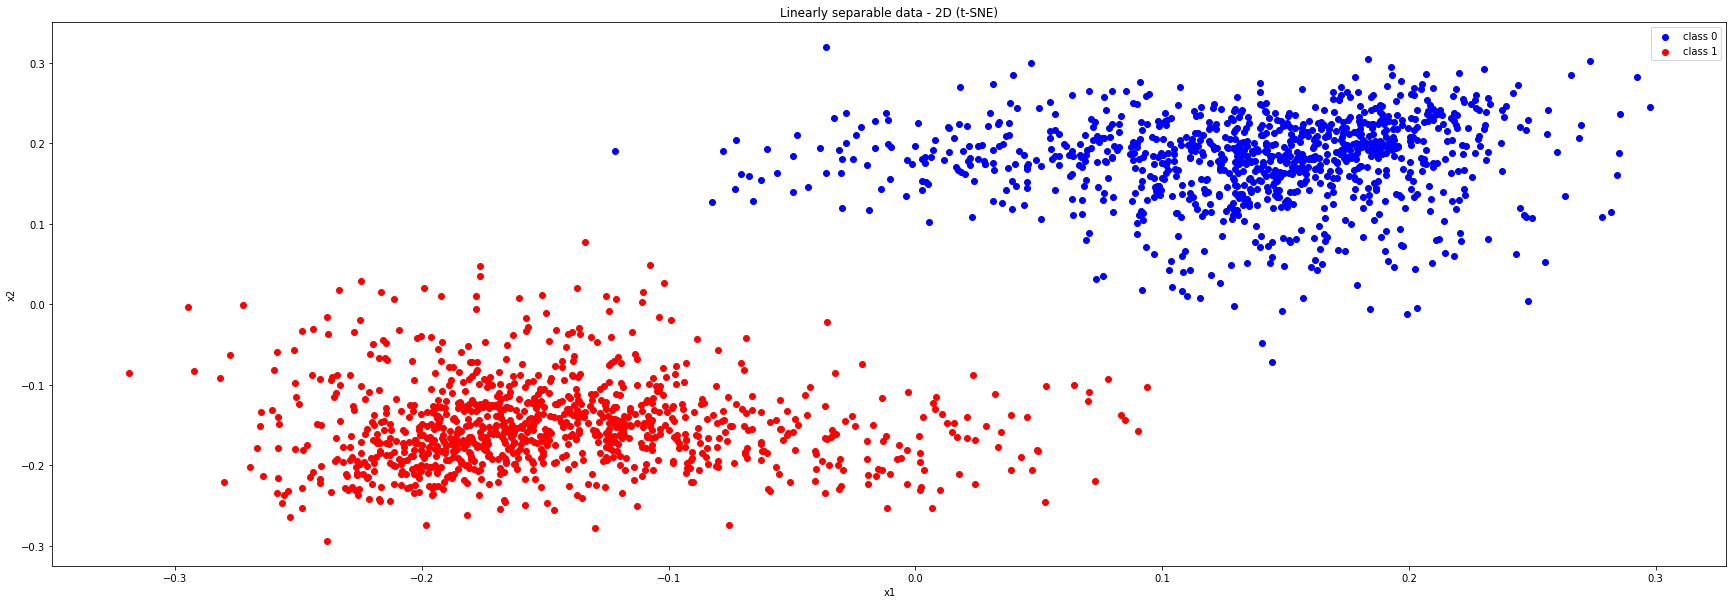

In [9]:
plt.figure(figsize=(30, 10))
plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], c='b', label='class 0')
plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], c='r', label='class 1')
plt.title("Linearly separable data - 2D (t-SNE)")
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

## K-Means

Iter: 0
Iter: 10
Iter: 20
Iter: 30
Iter: 40
Iter: 50
Iter: 60
Iter: 70
Iter: 80
Iter: 90
Iter: 100
Iter: 110
Iter: 120
Iter: 130
Iter: 140
Iter: 150
Iter: 160
Iter: 170
Iter: 180
Iter: 190
Iter: 200
Iter: 210
Iter: 220
Iter: 230
Iter: 240
Iter: 250
Iter: 260
Iter: 270
Iter: 280
Iter: 290
Iter: 300
Accuracy = 100.0%


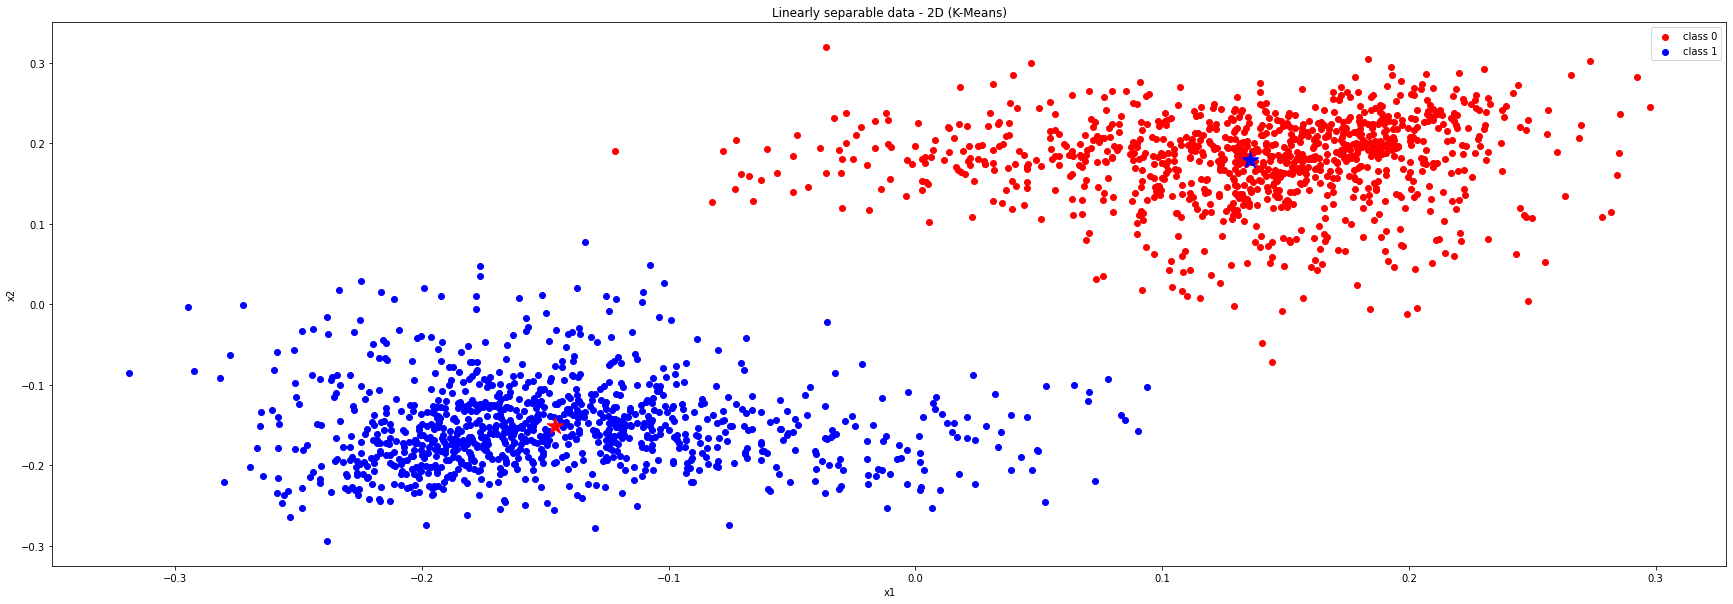

In [12]:
kmeans = kMeans(n_clusters=2, max_iters=301)
kmeans.fit(X_tsne)

accuracy = float("{:.2f}".format(100*np.mean(kmeans.cluster_labels == y)))
print(f"Accuracy = {accuracy}%")

marker_size = 300

plt.figure(figsize=(30, 10))
plt.scatter(X_tsne[kmeans.cluster_labels==0, 0], X_tsne[kmeans.cluster_labels==0, 1], c='r', label='class 0')
plt.scatter(X_tsne[kmeans.cluster_labels==1, 0], X_tsne[kmeans.cluster_labels==1, 1], c='b', label='class 1')
plt.scatter(kmeans.cluster_centers[0, 0], kmeans.cluster_centers[0, 1], s=marker_size, marker="*", c='b')
plt.scatter(kmeans.cluster_centers[1, 0], kmeans.cluster_centers[1, 1], s=marker_size, marker="*", c='r')
plt.title("Linearly separable data - 2D (K-Means)")
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

## Spectral-Clustering

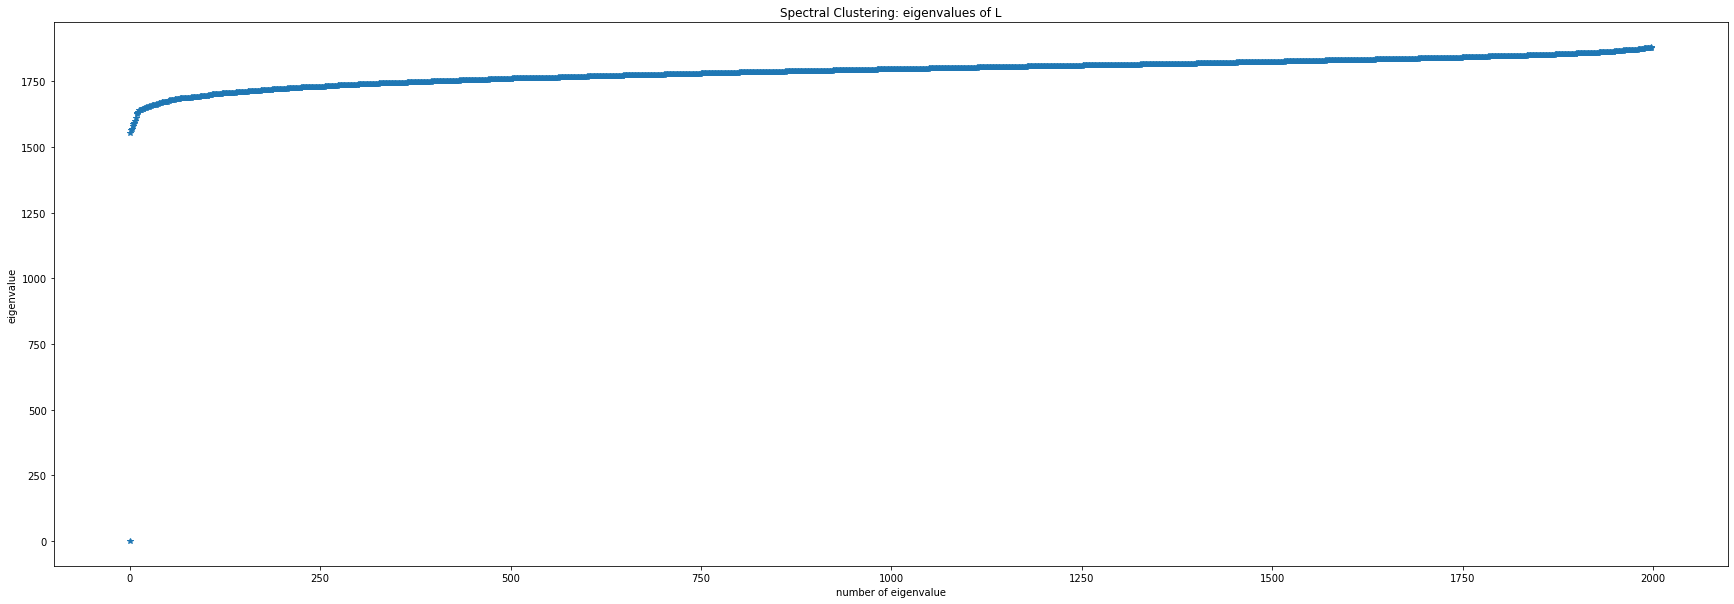

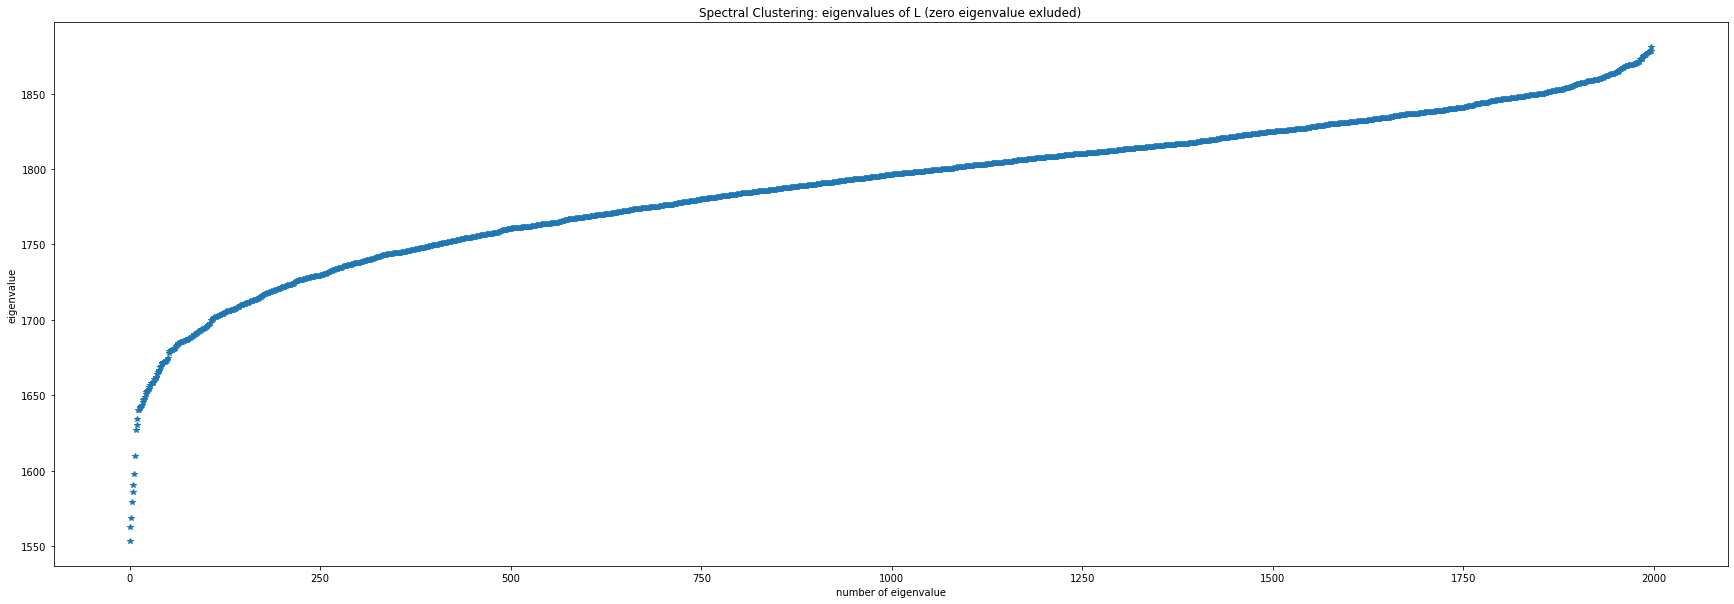

In [15]:
spectral_clustering = SpectralClustering(n_components=-2, first_eigval=0)
X_cl = spectral_clustering.fit_transform(X_scaled)

plt.figure(figsize=(30, 10))
plt.plot(spectral_clustering.lambdas, "*")
plt.xlabel("number of eigenvalue")
plt.ylabel("eigenvalue")
plt.title("Spectral Clustering: eigenvalues of L")
plt.show()

plt.figure(figsize=(30, 10))
plt.plot(spectral_clustering.lambdas[1:], "*")
plt.xlabel("number of eigenvalue")
plt.ylabel("eigenvalue")
plt.title("Spectral Clustering: eigenvalues of L (zero eigenvalue exluded)")
plt.show()

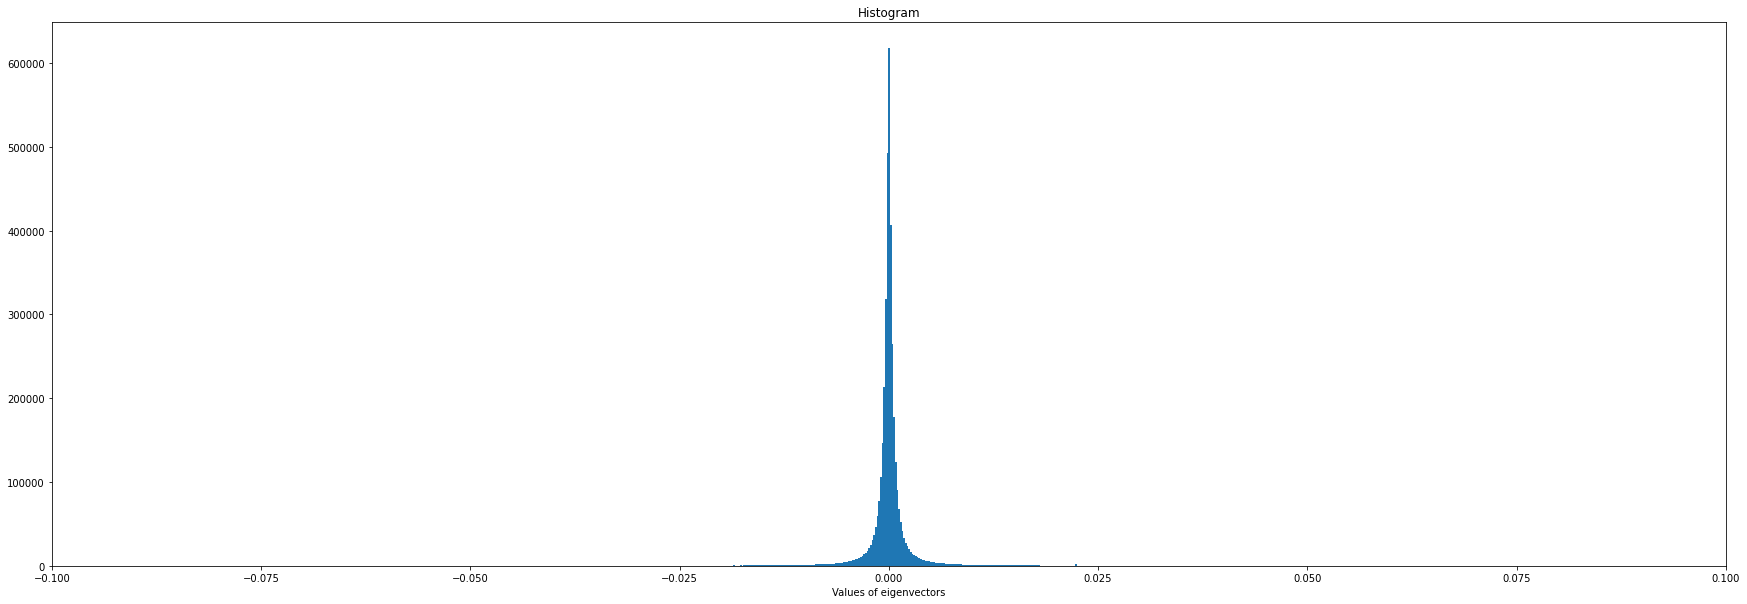

In [20]:
plt.figure(figsize=(30, 10))
plt.hist(spectral_clustering.V.flatten(), bins=10000)
plt.xlim([-0.1, 0.1])
plt.xlabel("Values of eigenvectors")
plt.title("Histogram")
plt.show()

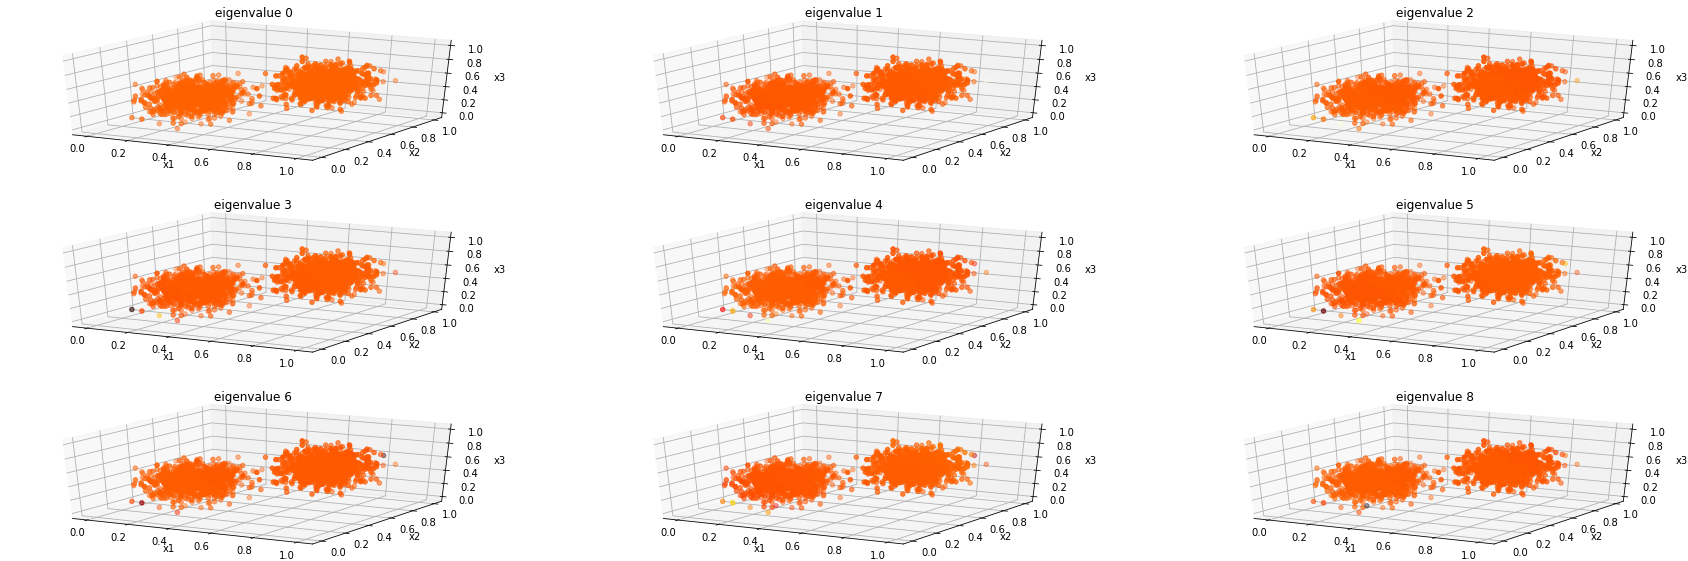

In [28]:
Z = (255 * (spectral_clustering.V - spectral_clustering.V.min()) / np.ptp(spectral_clustering.V)).astype(int)  
n_plots_x = 3
n_plots_y = 3
fig, axs = plt.subplots(n_plots_x, n_plots_y, subplot_kw=dict(projection="3d"), figsize=(30, 10))
cmap = plt.cm.hot
count = 0
for i in range(n_plots_x):
  for j in range(n_plots_y): 
    axs[i, j].scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], color=cmap(Z[:, count]))
    axs[i, j].set_xlabel("x1"), axs[i, j].set_ylabel("x2"), axs[i, j].set_zlabel("x3")
    axs[i, j].set_title(f"eigenvalue {count}")
    sm = plt.cm.ScalarMappable(cmap=cmap)
    count += 1

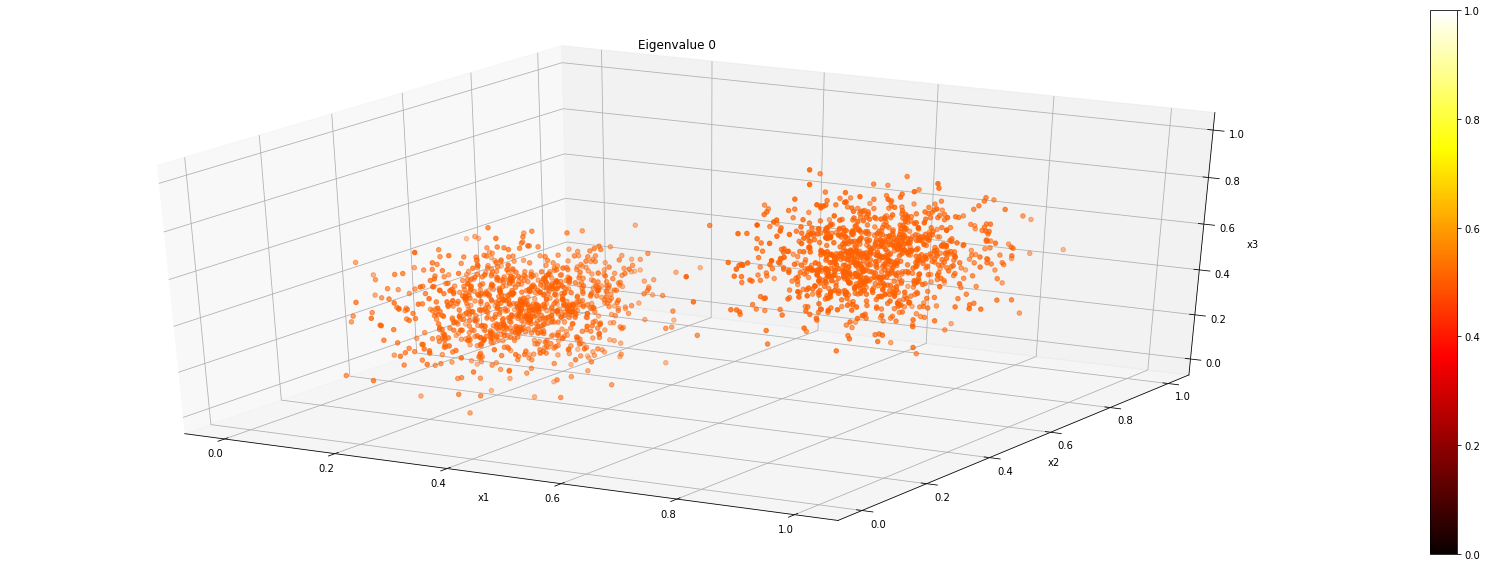

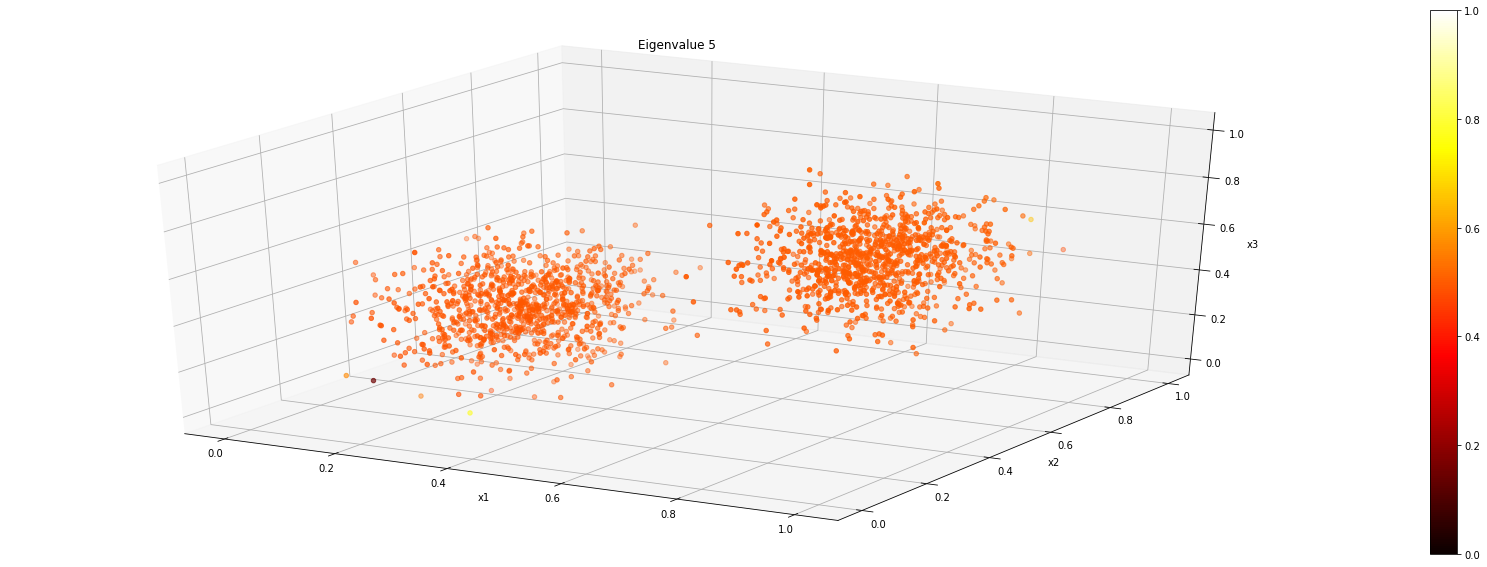

In [32]:
for n_eigval in [0, 5]:
  cmap = plt.cm.hot
  fig = plt.figure(figsize=(30, 10))
  ax = fig.add_subplot(projection='3d')
  ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], color=cmap(Z[:, n_eigval]))
  sm = plt.cm.ScalarMappable(cmap=cmap)
  fig.colorbar(sm)
  ax.set_xlabel("x1")
  ax.set_ylabel("x2")
  ax.set_zlabel("x3")
  ax.set_title(f"Eigenvalue {n_eigval}")
  plt.show()

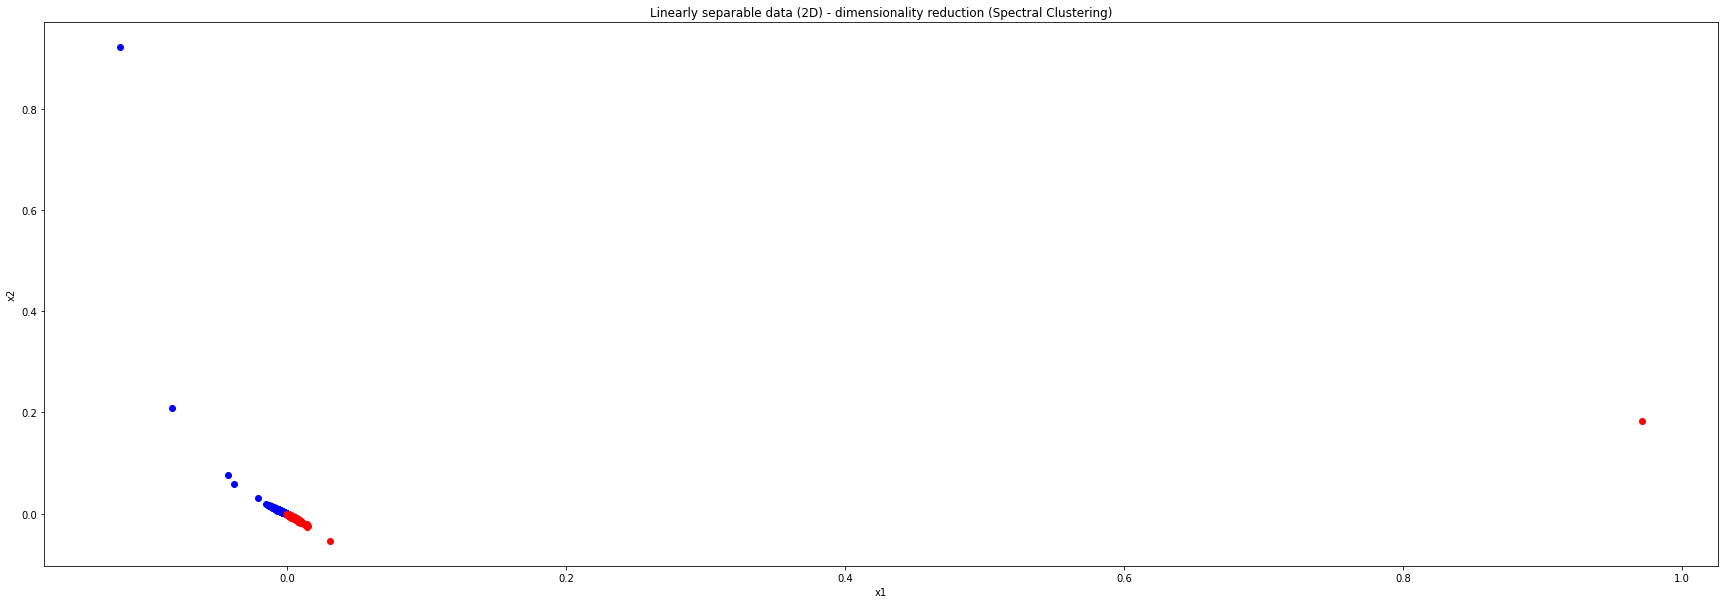

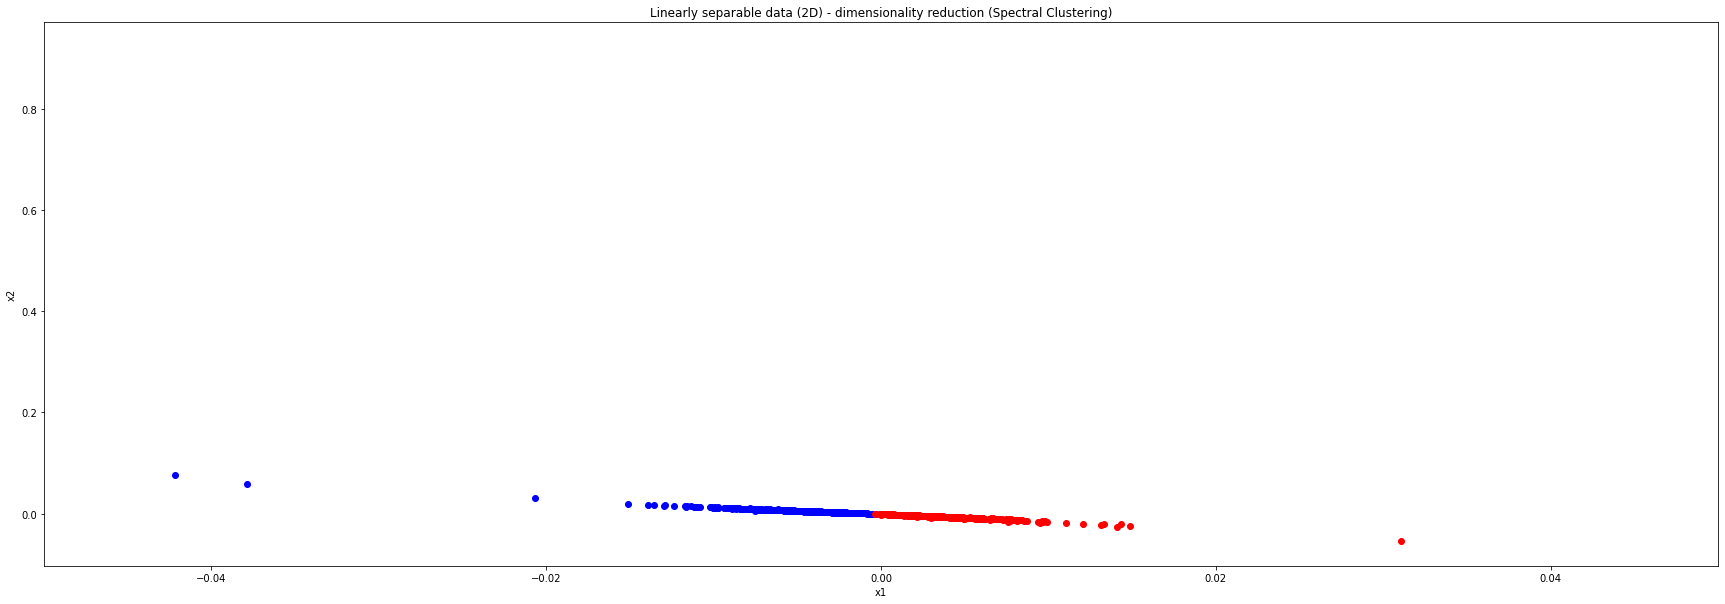

In [36]:
spectral_clustering = SpectralClustering(n_components=2, first_eigval=1)
X_cl = spectral_clustering.fit_transform(X_scaled)

plt.figure(figsize=(30, 10))
plt.scatter(X_cl[y==0, 0], X_cl[y==0, 1], c='b', label="class 0")
plt.scatter(X_cl[y==1, 0], X_cl[y==1, 1], c='r', label="class 1")
plt.xlabel("x1"), plt.ylabel("x2")
plt.title("Linearly separable data (2D) - dimensionality reduction (Spectral Clustering)")
plt.show()

plt.figure(figsize=(30, 10))
plt.scatter(X_cl[y==0, 0], X_cl[y==0, 1], c='b', label="class 0")
plt.scatter(X_cl[y==1, 0], X_cl[y==1, 1], c='r', label="class 1")
plt.xlabel("x1"), plt.ylabel("x2")
plt.title("Linearly separable data (2D) - dimensionality reduction (Spectral Clustering)")
plt.xlim([-0.05, 0.05])
plt.show()

In [37]:
kmeans = kMeans(n_clusters=2, max_iters=501)
kmeans.fit(X_cl)

accuracy = float("{:.2f}".format(100*np.mean(kmeans.cluster_labels == y)))
if accuracy < 50:
  accuracy = 100-accuracy
print(f"\nAccuracy = {accuracy}%")

Iter: 0
Iter: 10
Iter: 20
Iter: 30
Iter: 40
Iter: 50
Iter: 60
Iter: 70
Iter: 80
Iter: 90
Iter: 100
Iter: 110
Iter: 120
Iter: 130
Iter: 140
Iter: 150
Iter: 160
Iter: 170
Iter: 180
Iter: 190
Iter: 200
Iter: 210
Iter: 220
Iter: 230
Iter: 240
Iter: 250
Iter: 260
Iter: 270
Iter: 280
Iter: 290
Iter: 300
Iter: 310
Iter: 320
Iter: 330
Iter: 340
Iter: 350
Iter: 360
Iter: 370
Iter: 380
Iter: 390
Iter: 400
Iter: 410
Iter: 420
Iter: 430
Iter: 440
Iter: 450
Iter: 460
Iter: 470
Iter: 480
Iter: 490
Iter: 500

Accuracy = 100.0%


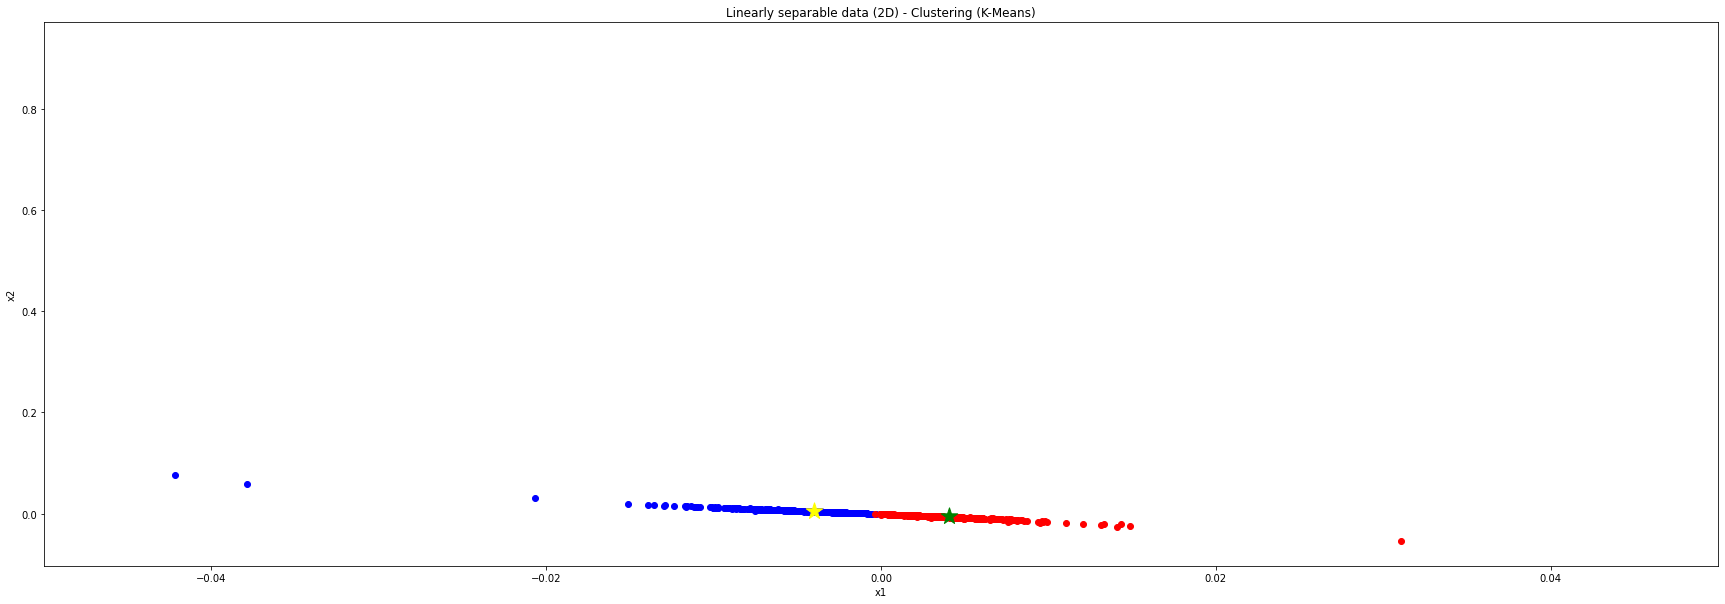

In [39]:
marker_size = 300

plt.figure(figsize=(30, 10))
plt.scatter(X_cl[kmeans.cluster_labels==0, 0], X_cl[kmeans.cluster_labels==0, 1], c='b')
plt.scatter(X_cl[kmeans.cluster_labels==1, 0], X_cl[kmeans.cluster_labels==1, 1], c='r')
plt.scatter(kmeans.cluster_centers[0, 0], kmeans.cluster_centers[0, 1], marker="*", s=marker_size, c='yellow')
plt.scatter(kmeans.cluster_centers[1, 0], kmeans.cluster_centers[1, 1], marker="*", s=marker_size, c='g')
plt.xlabel("x1"), plt.ylabel("x2")
plt.title("Linearly separable data (2D) - Clustering (K-Means)")
plt.xlim([-0.05, 0.05])
plt.show()